In [1]:
cd /home/rahul/python-dev/coursera/Computational-Investing/downloads/QSTK-0.2.8

/home/rahul/python-dev/coursera/Computational-Investing/downloads/QSTK-0.2.8


In [2]:
import QSTK.qstkutil.DataAccess as da
import QSTK.qstkutil.qsdateutil as du

import datetime as dt

/home/rahul/app_packages/anaconda3/envs/qstkpython2env/lib/python2.7/site-packages/QSTK/qstkutil/qsdateutil.py:36: FutureWarning: TimeSeries is deprecated. Please use Series
  return pd.TimeSeries(index=dates, data=dates)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
pd.set_option('max_rows', 10)
pd.set_option('max_columns', 10)

In [6]:
def get_symbol_list(list_name):
    data_object = da.DataAccess('Yahoo')
    return data_object.get_symbols_from_list(list_name)

# Example usage
# get_symbol_list('sp5002012')

In [7]:
AVAILABLE_PRICE_TYPES = ('open', 'high', 'low', 'close', 'volume', 'actual_close')


def get_price_dict(dt_start, dt_end, symbols, ls_price_type):
    assert all(price_type in AVAILABLE_PRICE_TYPES for price_type in ls_price_type)
    days = du.getNYSEdays(dt_start, dt_end, dt.timedelta(hours=16))
    c_dataobj = da.DataAccess('Yahoo')
    data_list = c_dataobj.get_data(days, symbols, ls_price_type)
    return dict(zip(ls_price_type, data_list))


def get_price_df(dt_start, dt_end, symbols, price_type='close'):
    assert price_type in AVAILABLE_PRICE_TYPES
    d_data = get_price_dict(dt_start, dt_end, symbols, [price_type])    
    return d_data[price_type]

# Example usage
# get_price_df(dt.date(2012, 1, 1), dt.date(2012, 1, 15), ["AAPL", "MSFT"], 'actual_close')

<h2> Event Profiling </h2>

In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size

[6.0, 4.0]

In [9]:
g_fig_size = [1.5 * x for x in fig_size]
plt.rcParams["figure.figsize"] = g_fig_size

In [10]:
dt_start = dt.datetime(2008, 1, 1)
dt_end = dt.datetime(2009, 12, 31)
ls_symbols = get_symbol_list('sp5002012')
ls_symbols.append("SPY")

In [11]:
df_all = get_price_df(dt_start, dt_end, ls_symbols)
df_all = df_all.fillna(method='bfill')
df_all = df_all.fillna(method='ffill')
df_all = df_all.fillna(1.0)

In [12]:
ts_market = df_all["SPY"]
d_data = {'close': df_all}

In [13]:
'''
Below is an excellent tutorial on how to apply opterations on dataframes

http://chrisalbon.com/python/pandas_apply_operations_to_dataframes.html
'''

def create_events_df(d_data, ts_market):
    df_close = d_data['close']
    # compute the returns of both series
    df_return = df_close / df_close.shift(1) - 1.0
    ts_market_return = ts_market / ts_market.shift(1) - 1.0
    # Event is found if the symbol is down more then 3% while the
            # market is up more then 2%
    df_return_bool = df_return <= -0.03
    ts_market_return_bool = ts_market_return >= 0.02
    # if both the conditions are true we have an event, which is indicated by 1 
    # otherwise there is no event which is indicated by np.nan    
    return df_return_bool.apply(lambda _ts_close: _ts_close & ts_market_return_bool) \
                         .applymap(lambda _x: 1 if _x else np.nan)

In [14]:
def eventprofiler(df_events_arg, d_data, i_lookback=20, i_lookforward=20,
                  b_market_neutral=True, s_market_sym='SPY'):
    
    df_close = d_data['close'].copy()  # Do not modify the original df
    df_rets = df_close / df_close.shift(1) - 1.0

    # Do not modify the original event dataframe.
    df_events = df_events_arg.copy()   # Do not modify the original df   

    if b_market_neutral == True:
        df_rets = df_rets.apply(lambda df_rets_column: df_rets_column - df_rets[s_market_sym])
        del df_rets[s_market_sym]
        del df_events[s_market_sym]

    df_close = df_close.reindex(columns=df_events.columns)

    # Removing the starting and the end events
    df_events[:i_lookback] = np.nan
    df_events[-i_lookforward:] = np.nan

    # Number of events
    i_no_events = int(np.sum(df_events.fillna(0).values))
    assert i_no_events > 0, "Zero events in the event matrix"
    
    na_event_rets = np.empty(shape=(0, 1 + i_lookback + i_lookforward))

    # Looking for the events and pushing them to a matrix
    for i, s_sym in enumerate(df_events.columns):
        for j, dt_date in enumerate(df_events.index):
            if df_events[s_sym][dt_date] == 1:
                na_ret = df_rets[s_sym][j - i_lookback:j + 1 + i_lookforward]
                na_event_rets = np.vstack((na_event_rets, na_ret))                    

    if len(na_event_rets.shape) == 1:
        na_event_rets = np.expand_dims(na_event_rets, axis=0)    
    
    # Computing daily rets and retuns
    na_event_rets = np.cumprod(na_event_rets + 1, axis=1)    
    na_event_rets = (na_event_rets.T / na_event_rets[:, i_lookback]).T      
    
    # Study Params
    na_mean = np.nanmean(na_event_rets, axis=0)
    na_std = np.nanstd(na_event_rets, axis=0)    
    li_time = range(-i_lookback, i_lookforward + 1)
    return i_no_events, pd.DataFrame({"mean": na_mean, "std": na_std}, index=li_time)    

In [15]:
def plot_profile(i_no_events, df_event_profile, b_market_neutral=True):
    # Plotting the chart
    li_time = df_event_profile.index
    na_mean = df_event_profile['mean']
    na_std = df_event_profile['std']
    i_lookback = np.abs(li_time[0])
    i_lookforward = np.abs(li_time[-1])
    
    plt.clf()
    plt.axhline(y=1.0, xmin=-i_lookback, xmax=i_lookforward, color='k')
    
    plt.errorbar(li_time[i_lookback:], na_mean[i_lookback:],
                yerr=na_std[i_lookback:], ecolor='#AAAAFF',
                alpha=0.7)
    plt.plot(li_time, na_mean, linewidth=3, label='mean', color='b')
    plt.xlim(-i_lookback - 1, i_lookforward + 1)
    if b_market_neutral == True:
        plt.title('Market Relative mean return of ' +\
                str(i_no_events) + ' events')
    else:
        plt.title('Mean return of ' + str(i_no_events) + ' events')
    plt.xlabel('Days')
    plt.ylabel('Cumulative Returns')

In [16]:
df_events = create_events_df(d_data, ts_market)

In [17]:
i_no_events, df_event_profile = eventprofiler(df_events, d_data, i_lookback=20, i_lookforward=20, 
                                              b_market_neutral=True, s_market_sym='SPY')

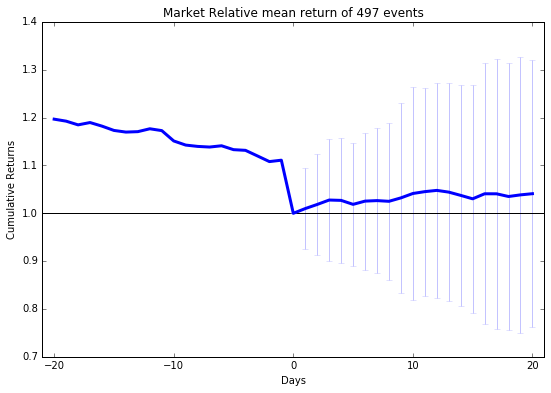

In [18]:
plot_profile(i_no_events, df_event_profile)

In [19]:
ls_symbols_sp5002008 =  get_symbol_list('sp5002008')
ls_symbols_sp5002012 =  get_symbol_list('sp5002012')

In [20]:
def create_events_type2_df(d_data, threshold=5):
    df_close = d_data['actual_close']
    df_close_lt_five = df_close < threshold
    df_close_gt_five = df_close >= threshold
    return (df_close_lt_five & df_close_gt_five.shift(1)).applymap(lambda x: 1 if x else np.nan)

In [21]:
ls_symbols_sp5002008.append('SPY')
ls_symbols_sp5002012.append('SPY')

In [22]:
d_data_2008 = get_price_dict(dt_start, dt_end, ls_symbols_sp5002008, ['close', 'actual_close'])
d_data_2012 = get_price_dict(dt_start, dt_end, ls_symbols_sp5002012, ['close', 'actual_close'])

In [23]:
df_events_2008 = create_events_type2_df(d_data_2008)
df_events_2012 = create_events_type2_df(d_data_2012)

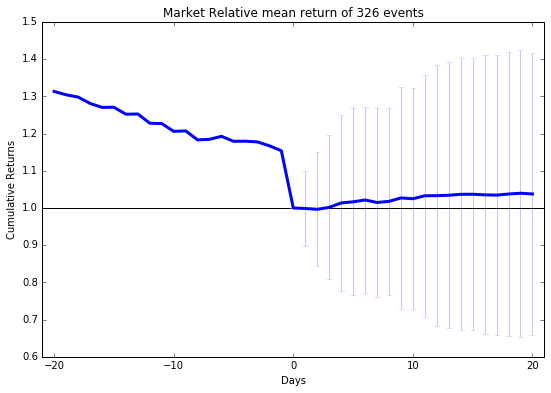

In [24]:
i_no_events, df_event_profile = eventprofiler(df_events_2008, d_data_2008, i_lookback=20, i_lookforward=20, 
                                              b_market_neutral=True, s_market_sym='SPY')

plot_profile(i_no_events, df_event_profile)

In [25]:
df_event_profile

,mean,std
-20,1.313260,1.015303
-19,1.304333,0.948702
-18,1.298205,0.921290
-17,1.281139,0.900547
-16,1.270409,0.932174
...,...,...
16,1.035353,0.375013
17,1.034659,0.376492
18,1.037564,0.382122
19,1.039695,0.385653


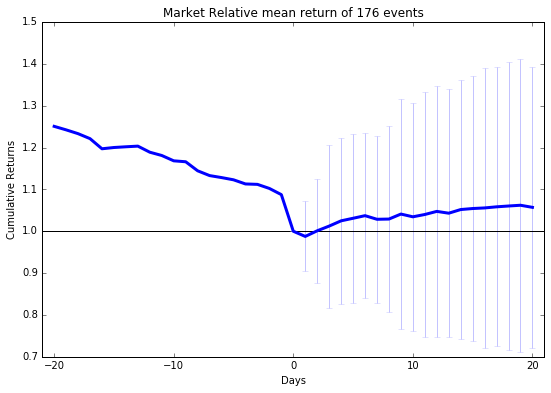

In [26]:
i_no_events, df_event_profile = eventprofiler(df_events_2012, d_data_2012, i_lookback=20, i_lookforward=20, 
                                              b_market_neutral=True, s_market_sym='SPY')

plot_profile(i_no_events, df_event_profile)

In [27]:
df_event_profile

,mean,std
-20,1.250665,0.604516
-19,1.242281,0.570937
-18,1.233182,0.549761
-17,1.221283,0.566519
-16,1.197075,0.515126
...,...,...
16,1.055725,0.334966
17,1.058371,0.333751
18,1.060327,0.343995
19,1.062122,0.349723


In [28]:
df_events_2008 = create_events_type2_df(d_data_2008, threshold=6)

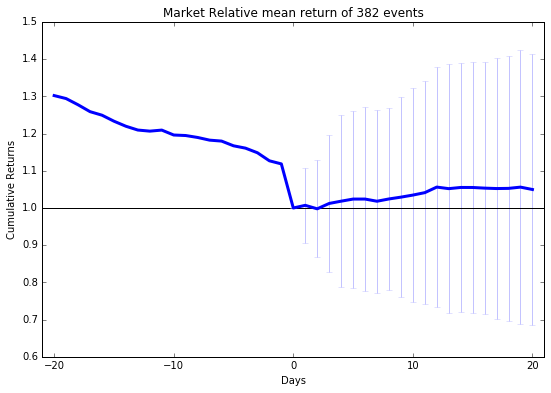

In [29]:
i_no_events, df_event_profile = eventprofiler(df_events_2008, d_data_2008, i_lookback=20, i_lookforward=20, 
                                              b_market_neutral=True, s_market_sym='SPY')

plot_profile(i_no_events, df_event_profile)

In [30]:
df_events_2008 = create_events_type2_df(d_data_2008, threshold=7)

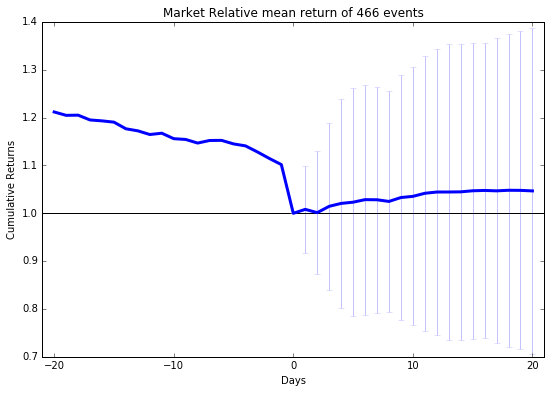

In [31]:
i_no_events, df_event_profile = eventprofiler(df_events_2008, d_data_2008, i_lookback=20, i_lookforward=20, 
                                              b_market_neutral=True, s_market_sym='SPY')

plot_profile(i_no_events, df_event_profile)

In [32]:
df_events_2008 = create_events_type2_df(d_data_2008, threshold=8)

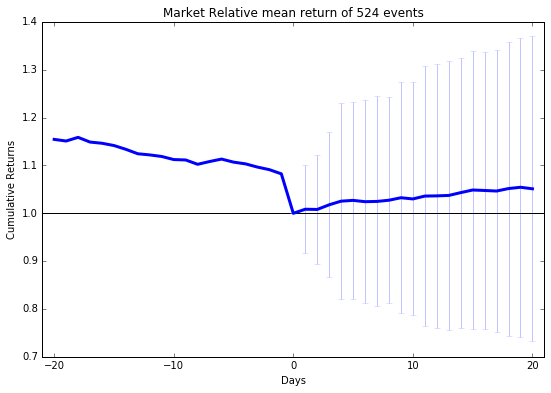

In [33]:
i_no_events, df_event_profile = eventprofiler(df_events_2008, d_data_2008, i_lookback=20, i_lookforward=20, 
                                              b_market_neutral=True, s_market_sym='SPY')

plot_profile(i_no_events, df_event_profile)

In [34]:
df_events_2008 = create_events_type2_df(d_data_2008, threshold=9)

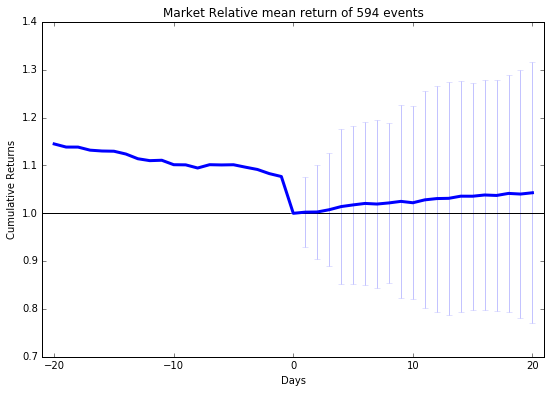

In [35]:
i_no_events, df_event_profile = eventprofiler(df_events_2008, d_data_2008, i_lookback=20, i_lookforward=20, 
                                              b_market_neutral=True, s_market_sym='SPY')

plot_profile(i_no_events, df_event_profile)

In [36]:
df_events_2008 = create_events_type2_df(d_data_2008, threshold=10)

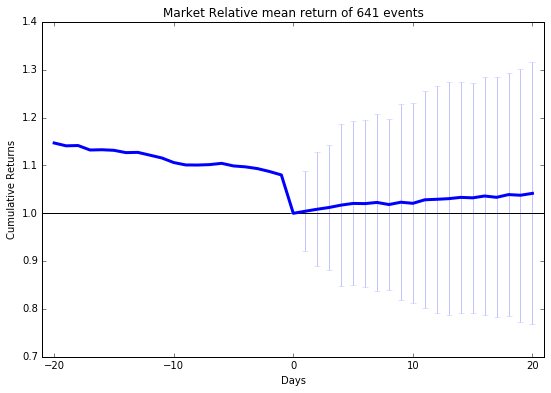

In [37]:
i_no_events, df_event_profile = eventprofiler(df_events_2008, d_data_2008, i_lookback=20, i_lookforward=20, 
                                              b_market_neutral=True, s_market_sym='SPY')

plot_profile(i_no_events, df_event_profile)

In [38]:
df_events_2012 = create_events_type2_df(d_data_2012, threshold=6)

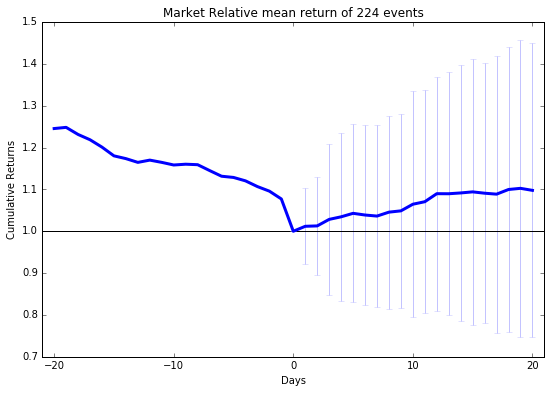

In [39]:
i_no_events, df_event_profile = eventprofiler(df_events_2012, d_data_2012, i_lookback=20, i_lookforward=20, 
                                              b_market_neutral=True, s_market_sym='SPY')

plot_profile(i_no_events, df_event_profile)

In [40]:
df_events_2012 = create_events_type2_df(d_data_2012, threshold=7)

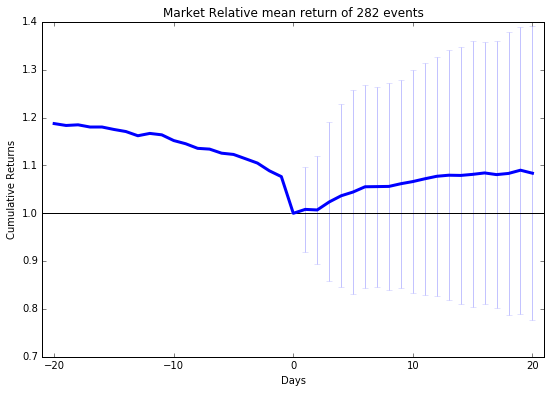

In [41]:
i_no_events, df_event_profile = eventprofiler(df_events_2012, d_data_2012, i_lookback=20, i_lookforward=20, 
                                              b_market_neutral=True, s_market_sym='SPY')

plot_profile(i_no_events, df_event_profile)

In [42]:
df_events_2012 = create_events_type2_df(d_data_2012, threshold=8)

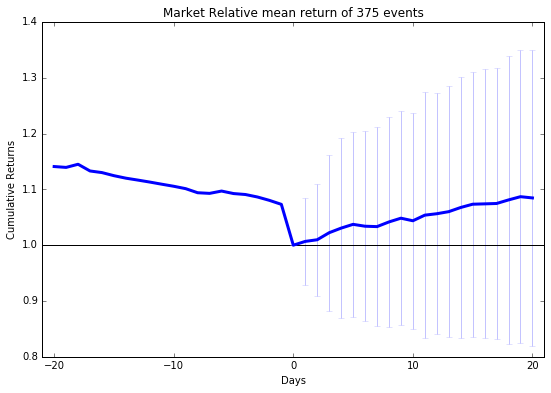

In [43]:
i_no_events, df_event_profile = eventprofiler(df_events_2012, d_data_2012, i_lookback=20, i_lookforward=20, 
                                              b_market_neutral=True, s_market_sym='SPY')

plot_profile(i_no_events, df_event_profile)

In [44]:
df_events_2012 = create_events_type2_df(d_data_2012, threshold=9)

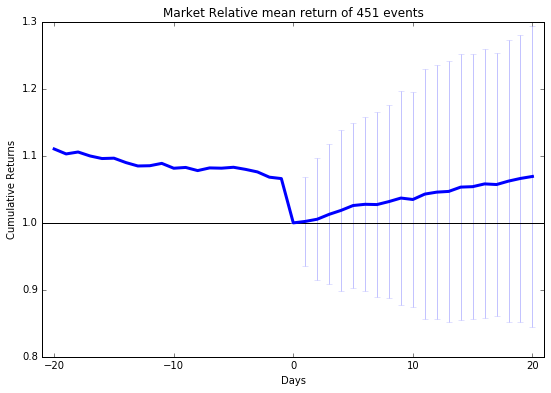

In [45]:
i_no_events, df_event_profile = eventprofiler(df_events_2012, d_data_2012, i_lookback=20, i_lookforward=20, 
                                              b_market_neutral=True, s_market_sym='SPY')

plot_profile(i_no_events, df_event_profile)

In [46]:
df_events_2012 = create_events_type2_df(d_data_2012, threshold=10)

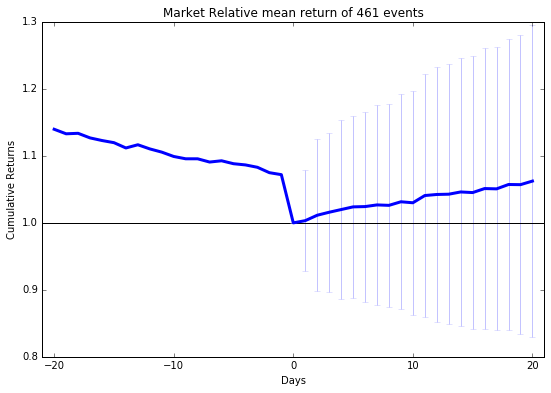

In [47]:
i_no_events, df_event_profile = eventprofiler(df_events_2012, d_data_2012, i_lookback=20, i_lookforward=20, 
                                              b_market_neutral=True, s_market_sym='SPY')

plot_profile(i_no_events, df_event_profile)